In [1]:
import Config as conf
import Lockin
import FileInfo
import matplotlib.pyplot as plt
%matplotlib qt
import numpy as np
import math
import os
import ROOT
import time

Welcome to JupyROOT 6.26/06


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-nishi_gaku'


In [2]:
StartNo = FileInfo.GetMaxFileNumber() + 1
StopNo  = conf.NumOfDataAcquisition
file_list = os.listdir(conf.DataPath)
data_list = []
print(conf.DataPath)

for i in range(len(file_list)):
    if ".bin" == os.path.splitext(file_list[i])[1]:
        data_list.append(os.path.join(conf.DataPath, file_list[i]))

print(len(data_list))

for i in range(len(data_list)):
    BinaryFileName = data_list[i]
    V, Time = Lockin.Lockin(BinaryFileName)
    #V = np.array([V[i] + 0.05*np.exp(-100*Time[i]) for i in range(len(V))])
    #print("read %d th data" %i)
    if i == 0:
        #plt.plot(Time, V, ".")
        #plt.show()
        V_mean = np.array([0.0 for i in range(len(V))])
    V_mean += V


[1]
/home/nishi_gaku/FIDNMR//Data/2023/0614/129Xe_069A_19kHz/run2/
1


In [3]:
def FindFreqDeltaLockin(StartF, EndF, Naverage, Time, V_mean):
    FreqList = []
    deltaList = []
    LockinList = []
    
    deltaRange = np.linspace(0., 2*math.pi, 10)
    #deltaRange = np.linspace(0.9*math.pi, 1.1*math.pi, 50)
    for f0 in range(StartF, EndF, 10):
        for delta in deltaRange:
            LockinValue = 0
            for i in range(Naverage):
                LockinValue += V_mean[i]*math.cos(2*math.pi*f0*Time[i]+delta)
                if i == Naverage-1:
                    FreqList.append(f0)
                    deltaList.append(delta)
                    LockinList.append(LockinValue)
                    
    return FreqList, deltaList, LockinList

def FindFreqLockin(StartF, EndF, dFreq, Naverage, Time, V_mean):
    FreqList = []
    LockinList = []
    
    for f0 in range(StartF, EndF, dFreq):
        LockinValue = 0
        for i in range(Naverage):
            t0 = Time[0]
            #LockinValue += V_mean[i]*math.cos(2*math.pi*f0*Time[i]+math.pi)
            LockinValue += V_mean[i]*math.cos(2*math.pi*f0*Time[i])
            if i == Naverage-1:
                t1 = Time[i]
                FreqList.append(f0)
                LockinList.append(LockinValue/(t1-t0))
                    
    return FreqList, LockinList

def FindDeltaLockin(f0, Naverage, Time, V_mean):
    FreqList = []
    deltaList = []
    LockinList = []
    
    deltaRange = np.linspace(0., 2*math.pi, 10)
    for delta in deltaRange:
        LockinValue = 0
        for i in range(Naverage):
            t0 = Time[0]
            LockinValue += V_mean[i]*math.cos(2*math.pi*f0*Time[i]+delta)
            #LockinValue += V_mean[i]*math.cos(2*math.pi*f0*Time[i])
            if i == Naverage-1:
                t1 = Time[i]
                deltaList.append(delta)
                LockinList.append(LockinValue/(t1-t0))
                    
    return deltaList, LockinList

def FinalLockin(f0, delta, Nstart, Nend, Naverage, Time, V_mean):
    aveTime = []
    LockinList = []
    start_time = time.time()
    for  j in range(int((Nend-Nstart)/Naverage)):
        LockinValue = 0
        for i in range(j*Naverage, (j+1)*Naverage):
            t0 = Time[j*Naverage]
            t1 = Time[(j+1)*Naverage-1]
            t_ave = (t0+t1)/2
            LockinValue += V_mean[i]*math.cos(2*math.pi*f0*Time[i]+delta)
        aveTime.append(t_ave)
        LockinList.append(LockinValue/(t1-t0))
    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time normal:", execution_time, "seconds")
    return aveTime, LockinList



In [80]:
FreqList, deltaList, LockinList = FindFreqDeltaLockin(18000, 20000, 1000, Time, V_mean)
import pandas as pd
df = pd.DataFrame({"freq": FreqList, "delta":deltaList, "Lockin": LockinList})
df_s = df.sort_values(by = "Lockin", ascending=False)
print(df_s[:10])
"""
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(FreqList, deltaList, LockinList)
plt.show()
"""

       freq     delta     Lockin
923   18920  2.094395  10.304263
904   18900  2.792527  10.303978
998   18990  5.585054  10.293603
1017  19010  4.886922  10.292291
838   18830  5.585054  10.291966
810   18810  0.000000  10.290073
819   18810  6.283185  10.290073
1083  19080  2.094395  10.259039
1102  19100  1.396263  10.256138
744   18740  2.792527  10.255416


"\nfig = plt.figure()\nax = fig.add_subplot(projection='3d')\nax.scatter(FreqList, deltaList, LockinList)\nplt.show()\n"

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(FreqList, deltaList, LockinList)
plt.show()

In [35]:
Naverage = 10000

FreqList, LockinList = FindFreqLockin(17000, 20000, 1, Naverage, Time, V_mean)
"""
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(FreqList, LockinList)
plt.show()
"""

'\nfig = plt.figure()\nax = fig.add_subplot()\nax.scatter(FreqList, LockinList)\nplt.show()\n'

In [ ]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
gr = ROOT.TGraph(len(FreqList), np.array(FreqList, dtype="d"), np.array(LockinList))
gr.Draw("APL")
gr.SetMarkerStyle(7)
gr.SetMarkerSize(10)
gr.SetTitle("average = %d"%Naverage)
gr.GetXaxis().SetTitle("f_s [Hz]")
#c1 = ROOT.gROOT.FindObject("c1")
c1.Draw("same")
#c1.Update()

In [34]:
Naverage = 1000
#aveTime, LockinList = FinalLockin(18270, 5.394654, 0, 150000, Naverage, Time, V_mean) #0616/131Xe_234_19kHz/run2
aveTime, LockinList = FinalLockin(18920, 2.094395, 0, 150000, Naverage, Time, V_mean) #0614/129Xe_069_19kHz/run2
#aveTime, LockinList = FinalLockin(18920, 0.5*math.pi, 0, 50000, Naverage, Time, V_mean) #0614/129Xe_069_19kHz/run2
"""
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(aveTime, LockinList, label = "average = %d"%Naverage)
#ax.scatter(aveTime, LockinList)
ax.grid()
ax.legend()
plt.show()
"""

Execution time normal: 0.05657196044921875 seconds


'\nfig = plt.figure()\nax = fig.add_subplot()\nax.plot(aveTime, LockinList, label = "average = %d"%Naverage)\n#ax.scatter(aveTime, LockinList)\nax.grid()\nax.legend()\nplt.show()\n'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


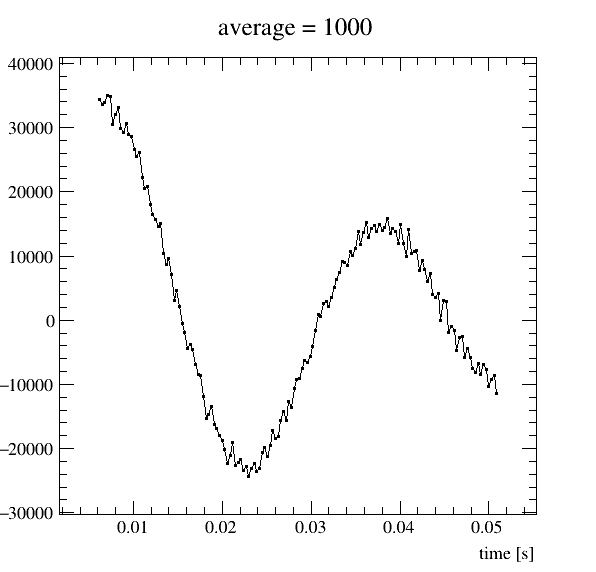

In [35]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
gr = ROOT.TGraph(len(aveTime), np.array(aveTime), np.array(LockinList))
gr.Draw("APL")
gr.SetMarkerStyle(7)
gr.SetMarkerSize(10)
gr.SetTitle("average = %d"%Naverage)
gr.GetXaxis().SetTitle("time [s]")
#c1 = ROOT.gROOT.FindObject("c1")
c1.Draw("same")
#c1.Update()

In [85]:
sampling_rate = 1/(Time[1]-Time[0])
sampling_rate

3333333.2154304865

In [61]:
1000/sampling_rate

0.0003000000106112566

/home/nishi_gaku/.local/lib/python3.10/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


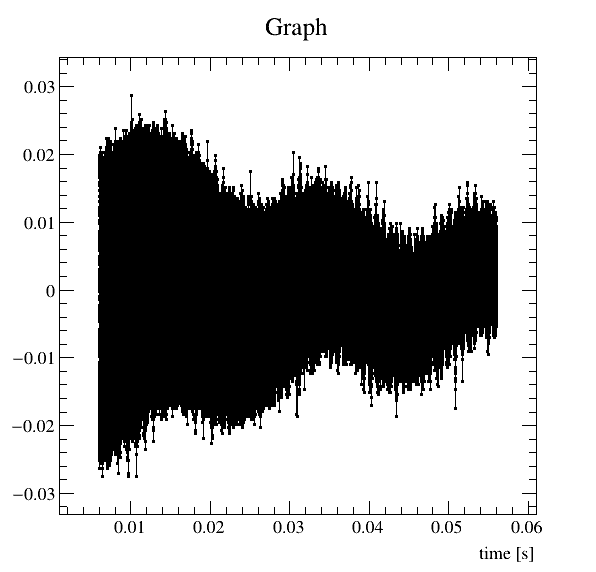

In [45]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
gr = ROOT.TGraph(len(Time), np.array(Time), np.array(V))
gr.Draw("APL")
gr.SetMarkerStyle(7)
gr.SetMarkerSize(10)
#gr.SetTitle("average = %d"%Naverage)
gr.GetXaxis().SetTitle("time [s]")
#c1 = ROOT.gROOT.FindObject("c1")
c1.Draw("same")
#c1.Update()